In [1]:
#Nicole Zawadzki
#ASTRO400B Project
#Finding the Tidal Radius of M33 Analytically

In [2]:
#import modules
import numpy as np
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassDistribution import MassProfile
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')

In [3]:
#read in COM data files for MW, M31, and M33
fMW = np.genfromtxt('Orbit_MW.txt', dtype=None, names=True)
fM31 = np.genfromtxt('Orbit_M31.txt', dtype=None, names=True)
fM33 = np.genfromtxt('Orbit_M33.txt', dtype=None, names=True)

In [11]:
def TidalRadiusPoint():
    #find the tidal radius analytically throughout the simulation assuming the galaxies are point masses
    #input: 
    #return: tidal radius throughout simulation
        
    #find separation between M33 and M31
    x = abs(fM31['x'] - fM33['x'])
    y = abs(fM31['y'] - fM33['y'])
    z = abs(fM31['z'] - fM33['z'])
    R = np.sqrt(x**2 + y**2 + z**2)
    
    #find separation between M33 and MW
    x1 = abs(fMW['x'] - fM33['x'])
    y1 = abs(fMW['y'] - fM33['y'])
    z1 = abs(fMW['z'] - fM33['z'])
    R1 = np.sqrt(x1**2 + y1**2 + z1**2)
    
    #find separation between MW and M31
    x2 = abs(fM31['x'] - fMW['x'])
    y2 = abs(fM31['y'] - fMW['y'])
    z2 = abs(fM31['z'] - fMW['z'])
    R2 = np.sqrt(x2**2 + y2**2 + z2**2)
    
    Avg_R = np.sqrt(R**2 + R1**2)

    #Masses of disks
    MWDiskMass = 0.075e12 #Msun
    M31DiskMass = 0.120e12 #Msun    
    M33DiskMass = 0.009e12 #Msun
    
    r_t = np.zeros(shape=len(R))
    #loop over radius elements and find tidal radius at each point
    for i in range(len(R)):
        #when M31 and MW are far apart, only use M31 mass as main perturber. Once M31 and MW are sufficiently close
        #and MW's potential is affecting M33 then need to take it's contibution into account. 
        if R2[i] > 20:
            r_t[i] = R[i]*(M33DiskMass/(2.0*M31DiskMass))**(1.0/3.0)
        
        else:
            r_t[i] = Avg_R[i]*(M33DiskMass/(2.0*(M31DiskMass+MWDiskMass)))**(1.0/3.0)
    
    return r_t

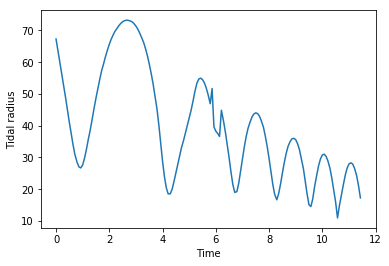

In [12]:
#plotting tidal radius vs time assuming all point sources
PointRadius = TidalRadiusPoint()
time = fM33['t']
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(time,PointRadius)
plt.xlabel('Time')
plt.ylabel('Tidal radius')

In [13]:
#adapt a mass profile
def TidalRadiusHernquist(galaxy1, galaxy2, galaxy3, snap):
    #adopting a mass profile to calculate the tidal radius of M33 
    #input: galaxy names, snap number, and radius array
    #return: array with tidal radii throughout the simulation
       
    #find separation between M33 and M31
    x = abs(fM31['x'] - fM33['x'])
    y = abs(fM31['y'] - fM33['y'])
    z = abs(fM31['z'] - fM33['z'])
    R = np.sqrt(x**2 + y**2 + z**2)
    
    #find separation between M33 and MW
    x1 = abs(fMW['x'] - fM33['x'])
    y1 = abs(fMW['y'] - fM33['y'])
    z1 = abs(fMW['z'] - fM33['z'])
    R1 = np.sqrt(x1**2 + y1**2 + z1**2)
    
    #find separation between MW and M31
    x2 = abs(fM31['x'] - fMW['x'])
    y2 = abs(fM31['y'] - fMW['y'])
    z2 = abs(fM31['z'] - fMW['z'])
    R2 = np.sqrt(x2**2 + y2**2 + z2**2)

    #Masses of disks
    MWDiskMass = 0.075e12 #Msun
    M31DiskMass = 0.120e12 #Msun    
    M33DiskMass = 0.009e12 #Msun
    
    #Masses of halos
    MWHaloMass = 1.975e12
    M31HaloMass = 1.921e12
    M33HaloMass = 0.187e12
    
    #scale factor for galaxies
    MWa = 61 #kpc
    M31a = 62 #kpc
    M33a = 25 #kpc
    
    #create class objects for each galaxy profile
    MWMass = MassProfile(galaxy3,snap)
    M31Mass = MassProfile(galaxy2,snap)
    M33Mass = MassProfile(galaxy1,snap)
    
    #find the Hernquist profile for M33 and M31 while they are far from MW
    #using scale factors from solutions to homework 5
    #takes radius array, scale factor and halo mass as input
    M31Hernquist = M31Mass.HernquistMass(R,M31a,M31HaloMass)
    M33Hernquist = M33Mass.HernquistMass(R,M33a,M33HaloMass)
    
    #find Hernquist profiles at the average distance of MW-M33 and M31-M33 distance
    #at some point MW's potential has significants and need to take it into account
    Avg_R = np.sqrt(R**2 + R1**2)
    Avg_M33Hernquist = M33Mass.HernquistMass(Avg_R,M33a,M33HaloMass)
    Avg_M31Hernquist = M31Mass.HernquistMass(Avg_R,M31a,M31HaloMass)
    Avg_MWHernquist = MWMass.HernquistMass(Avg_R,MWa,MWHaloMass)
    
    r_t = np.zeros(shape=len(R))
    
    for i in range(len(R)):
        #if MW and M31 are greater than 20kpc away can assume that M31 is the dominant potential in the tidal radius
        #since M31 and MW disk radii and both between 15-20kpc can assume that when their center of masses are close
        if R2[i] > 20:
            r_t[i] = R[i]*(M33Hernquist[i]/(2*M31Hernquist[i]))**(1.0/3.0)
            
        else:
            r_t[i] = Avg_R[i]*(Avg_M33Hernquist[i]/(2*(Avg_M31Hernquist[i]
                                                    +Avg_MWHernquist[i])))**(1.0/3.0) 
            
    return r_t                                                              
        

In [14]:
def TidalRadiusInter(galaxy1,galaxy2,galaxy3,snap):
    #function doing same as above but assuming M33 is point mass and MW/M31 have extended profiles
    #input: name of galaxies, and snapshot number
    #return: array of tidal radii along the orbit
    
    #find separation between M33 and M31
    x = abs(fM31['x'] - fM33['x'])
    y = abs(fM31['y'] - fM33['y'])
    z = abs(fM31['z'] - fM33['z'])
    R = np.sqrt(x**2 + y**2 + z**2)
    
    #find separation between M33 and MW
    x1 = abs(fMW['x'] - fM33['x'])
    y1 = abs(fMW['y'] - fM33['y'])
    z1 = abs(fMW['z'] - fM33['z'])
    R1 = np.sqrt(x1**2 + y1**2 + z1**2)
    
    #find separation between MW and M31
    x2 = abs(fM31['x'] - fMW['x'])
    y2 = abs(fM31['y'] - fMW['y'])
    z2 = abs(fM31['z'] - fMW['z'])
    R2 = np.sqrt(x2**2 + y2**2 + z2**2)

    #Masses of disks
    MWDiskMass = 0.075e12 #Msun
    M31DiskMass = 0.120e12 #Msun    
    M33DiskMass = 0.009e12 #Msun
    
    #Masses of halos
    MWHaloMass = 1.975e12
    M31HaloMass = 1.921e12
    M33HaloMass = 0.187e12
    
    #scale factor for galaxies
    MWa = 61 #kpc
    M31a = 62 #kpc
    M33a = 25 #kpc
    
    #create class objects for each galaxy profile
    MWMass = MassProfile(galaxy3,snap)
    M31Mass = MassProfile(galaxy2,snap)
    M33Mass = MassProfile(galaxy1,snap)
    
    #find the Hernquist profile for M33 and M31 while they are far from MW
    #using scale factors from solutions to homework 5
    #takes radius array, scale factor and halo mass as input
    M31Hernquist = M31Mass.HernquistMass(R,M31a,M31HaloMass)
    M33Hernquist = M33Mass.HernquistMass(R,M33a,M33HaloMass)
    
    #find Hernquist profiles at the average distance of MW-M33 and M31-M33 distance
    #at some point MW's potential has significants and need to take it into account
    Avg_R = np.sqrt(R**2 + R1**2)
    Avg_M33Hernquist = M33Mass.HernquistMass(Avg_R,M33a,M33HaloMass)
    Avg_M31Hernquist = M31Mass.HernquistMass(Avg_R,M31a,M31HaloMass)
    Avg_MWHernquist = MWMass.HernquistMass(Avg_R,MWa,MWHaloMass)
    
    r_t = np.zeros(shape=len(R))
    
    for i in range(len(R)):
        if R2[i] > 20:
            r_t[i] = R[i]*(M33DiskMass/(2*M31Hernquist[i]))**(1.0/3.0)
            
        else:
            r_t[i] = Avg_R[i]*(M33DiskMass/(2*(Avg_M31Hernquist[i]+Avg_MWHernquist[i])))**(1.0/3.0) 
            
    return r_t                                                           


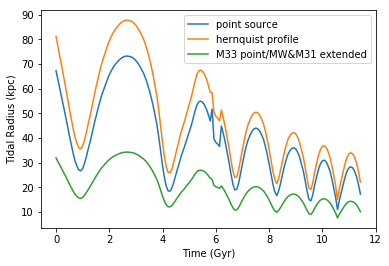

In [17]:
#plot all three tidal radii arrays
r = np.logspace(-1,1.477,50)
HernquistRadius = TidalRadiusHernquist('M33','M31','MW',0)
InterRadius = TidalRadiusInter('M33','M31','MW',0)

time = fM33['t']
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(time,PointRadius, label='point source')
plt.plot(time,HernquistRadius, label='hernquist profile')
plt.plot(time,InterRadius, label='M33 point/MW&M31 extended')
legend = ax.legend()
plt.xlabel('Time (Gyr)')
plt.ylabel('Tidal Radius (kpc)')
#plt.title('Analytic Tidal Radius Solution')

# Save to a file
ax.set_rasterized(True)
plt.savefig('AnalyticTIdalRadius.eps', rasterized=True, dpi=350)

In [16]:
#printing the tidal radius for the extended profiles case at the desired snapshots
#this is taken and used in the DensityProfile notebook for comparing to density profiles and histograms
timearray = [0,0.07,1,2.79,4.36,5.5,6.86,7.57,8.36,9,9.64,10.14,10.64,11.14]
radiusarray = np.zeros(shape=len(timearray))
count = 0
for t in timearray:
    index = np.where(time==t)
    radiusarray[count] = HernquistRadius[index]
    count = count+1
print radiusarray

[ 81.2250102   77.25865241  36.736648    87.49144999  27.8029702
  67.04157738  27.163958    50.23613576  23.64408111  41.71007383
  21.76678945  36.23119457  19.35584701  33.64292516]
